## Step 1 - Import Libraries

In [1]:
# Importing  Libraries

import warnings
warnings.filterwarnings("ignore")
from numpy.random import seed
seed(42)

import pandas as pd
import numpy as np


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import os
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
tf.random.set_seed(42)

2025-12-04 05:49:21.315284: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764827361.517366      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764827361.569751      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
# Setting Some Pre-Requisites
IMAGE_SIZE=96
IMAGE_CHANNELS=3
SAMPLE_SIZE=80000         # We will be training 80,000 samples from each label

## Step 2 - Looking at the data

In [3]:
#What files are available
os.listdir('../input/histopathologic-cancer-detection')

['sample_submission.csv', 'train_labels.csv', 'test', 'train']

In [4]:
#Lets check how much data are we working with!
print(len(os.listdir('../input/histopathologic-cancer-detection/train')))
print(len(os.listdir('../input/histopathologic-cancer-detection/test')))

220025
57458


In [5]:
#lets put the training images in a dataframe
df_data = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')
print(df_data.shape)

(220025, 2)


In [6]:
df_data['label'].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

In [7]:
def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """
    

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) 
    
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['id'] + '.tif'
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()

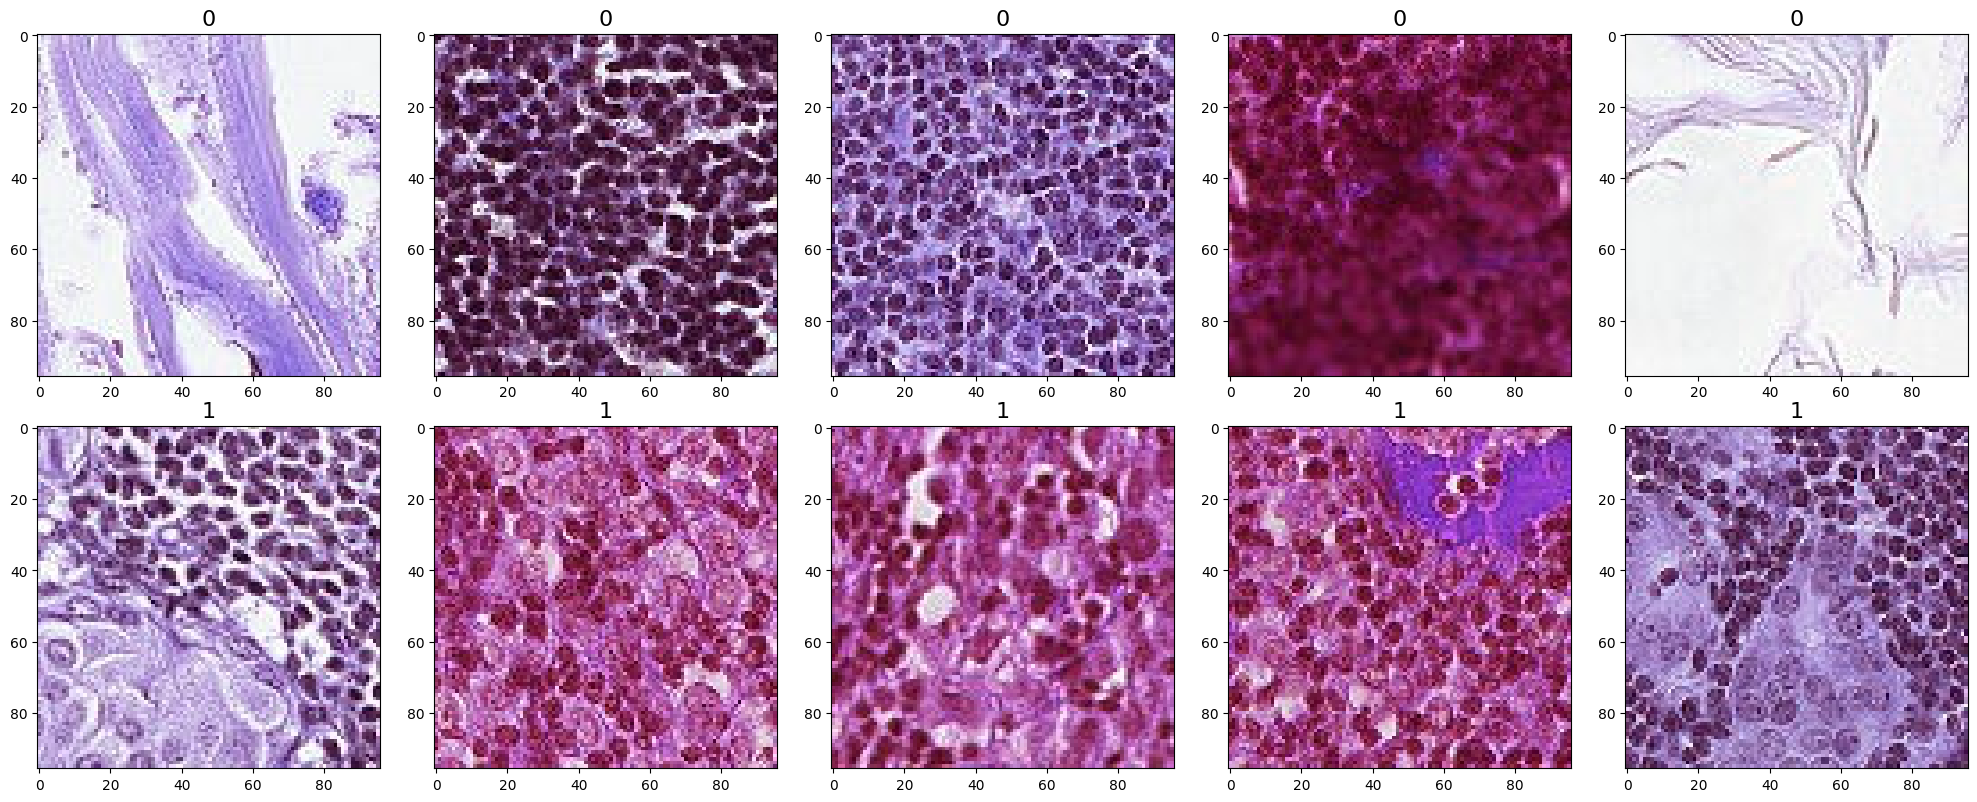

In [8]:
IMAGE_PATH = '../input/histopathologic-cancer-detection/train/' 

draw_category_images('label',5, df_data, IMAGE_PATH)

## Step 3 - Create and concat the training and validation sets

In [9]:
# Create the Train and Validation Sets

df_0=df_data[df_data['label']==0].sample(SAMPLE_SIZE,random_state=101)
df_1=df_data[df_data['label']==1].sample(SAMPLE_SIZE,random_state=101)

# concat the dataframes
df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
# shuffle
df_data = shuffle(df_data)

df_data['label'].value_counts()

label
0    80000
1    80000
Name: count, dtype: int64

In [10]:
#ok now let-s split the data
y = df_data['label']

df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=42, stratify=y) #Stratify creates a balances validation set!

print(df_train.shape)
print(df_val.shape)

(144000, 2)
(16000, 2)


## Step 4 -  Create a new directory so that we will be using the ImageDataGenerator


In [11]:
base_dir='base_dir'
os.mkdir(base_dir)

# now we create 2 folders inside 'base_dir':

# train_dir
    # a_no_tumor_tissue
    # b_has_tumor_tissue

# val_dir
    # a_no_tumor_tissue
    # b_has_tumor_tissue



# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)



# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
no_tumor_tissue = os.path.join(train_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(train_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)


# create new folders inside val_dir
no_tumor_tissue = os.path.join(val_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(val_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)

In [12]:
#lets check the directory to make sure we did the right thing
os.listdir('base_dir/train_dir')

['a_no_tumor_tissue', 'b_has_tumor_tissue']

In [13]:
#put id as an index in our dataframe
df_data.set_index('id', inplace=True)

In [14]:
df_data

,label
id,
5c107cd8243e2f799ee16b7c314797b28554fd8f,0
6af96a56880eb5fcdd253324f4e832d204c60ace,1
a0dbcb34de991ae004554cf2016324bc6d16c0cf,0
775c32f97f11fe8bdbf0f898b2351d484c7183c3,1
e7dd7cfc05e1550660735660da98b662dfb60827,1
...,...
f72899c974bc6d37a11a1a9f68a6d29d1d8f2f28,0
726e67c173fdc659699a18a31afbb26b4f8ffd0a,0
583444c097d63a0f700a5e0530be51914a91ed51,1


In [15]:
# Get a list of train and val images
train_list = list(df_train['id'])
val_list = list(df_val['id'])



# Transfer the train images

for image in train_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'a_no_tumor_tissue'
    if target == 1:
        label = 'b_has_tumor_tissue'
    
    # source path to image
    src = os.path.join('../input/histopathologic-cancer-detection/train', fname)
    # destination path to image
    dst = os.path.join(train_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'a_no_tumor_tissue'
    if target == 1:
        label = 'b_has_tumor_tissue'
    

    # source path to image
    src = os.path.join('../input/histopathologic-cancer-detection/train', fname)
    # destination path to image
    dst = os.path.join(val_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [16]:
# check how many train images we have in each folder

print(len(os.listdir('base_dir/train_dir/a_no_tumor_tissue')))
print(len(os.listdir('base_dir/train_dir/b_has_tumor_tissue')))

72000
72000


In [17]:
# Set up the generators
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'
test_path = '../input/histopathologic-cancer-detection/test'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10


train_steps = int(np.ceil(num_train_samples / train_batch_size))
val_steps = int(np.ceil(num_val_samples / val_batch_size))

## Step 5 - Implement the Imagegenerator on all 3 splits

In [18]:
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


## Step 6 - Build the CNN model

In [19]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()

I0000 00:00:1764828579.264722      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764828579.265384      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 92, 92, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 90, 90, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 43, 43, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 41, 41, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 39, 39, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 13, 13, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,661,186 (6.34 MB)

 Trainable params: 1,661,186 (6.34 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

In [21]:
# Get the labels that are associated with each index
print(val_gen.class_indices)

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}


In [22]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'compile_metrics']

## Step 7 - Save the model weights for prediction submission

In [23]:
filepath = "model.h5"

checkpoint = ModelCheckpoint(
    filepath,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=2,
    verbose=1,
    mode='max',
    min_lr=1e-5
)

callbacks_list = [checkpoint, reduce_lr]

history = model.fit(
    train_gen,
    steps_per_epoch=train_steps,
    validation_data=val_gen,
    validation_steps=val_steps,
    epochs=20,
    verbose=1,
    callbacks=callbacks_list
)

Epoch 1/20


I0000 00:00:1764828584.000922     155 service.cc:148] XLA service 0x7d11480075c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764828584.001623     155 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764828584.001645     155 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764828584.569555     155 cuda_dnn.cc:529] Loaded cuDNN version 90300


   10/14400 ━━━━━━━━━━━━━━━━━━━━ 4:22 18ms/step - accuracy: 0.5216 - loss: 0.6936

I0000 00:00:1764828590.590693     155 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


14398/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7484 - loss: 0.4994
Epoch 1: val_accuracy improved from -inf to 0.82394, saving model to model.h5


14400/14400 ━━━━━━━━━━━━━━━━━━━━ 189s 12ms/step - accuracy: 0.7484 - loss: 0.4994 - val_accuracy: 0.8239 - val_loss: 0.4002 - learning_rate: 1.0000e-04
Epoch 2/20
14397/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8434 - loss: 0.3588
Epoch 2: val_accuracy improved from 0.82394 to 0.87569, saving model to model.h5


14400/14400 ━━━━━━━━━━━━━━━━━━━━ 180s 13ms/step - accuracy: 0.8434 - loss: 0.3588 - val_accuracy: 0.8757 - val_loss: 0.2909 - learning_rate: 1.0000e-04
Epoch 3/20
14396/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8726 - loss: 0.3011
Epoch 3: val_accuracy improved from 0.87569 to 0.88956, saving model to model.h5


14400/14400 ━━━━━━━━━━━━━━━━━━━━ 179s 12ms/step - accuracy: 0.8726 - loss: 0.3011 - val_accuracy: 0.8896 - val_loss: 0.2630 - learning_rate: 1.0000e-04
Epoch 4/20
14397/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8867 - loss: 0.2731
Epoch 4: val_accuracy improved from 0.88956 to 0.89587, saving model to model.h5


14400/14400 ━━━━━━━━━━━━━━━━━━━━ 178s 12ms/step - accuracy: 0.8867 - loss: 0.2731 - val_accuracy: 0.8959 - val_loss: 0.2506 - learning_rate: 1.0000e-04
Epoch 5/20
14396/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9000 - loss: 0.2481
Epoch 5: val_accuracy improved from 0.89587 to 0.89994, saving model to model.h5


14400/14400 ━━━━━━━━━━━━━━━━━━━━ 179s 12ms/step - accuracy: 0.9000 - loss: 0.2481 - val_accuracy: 0.8999 - val_loss: 0.2496 - learning_rate: 1.0000e-04
Epoch 6/20
14398/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9045 - loss: 0.2362
Epoch 6: val_accuracy improved from 0.89994 to 0.91325, saving model to model.h5


14400/14400 ━━━━━━━━━━━━━━━━━━━━ 178s 12ms/step - accuracy: 0.9045 - loss: 0.2362 - val_accuracy: 0.9133 - val_loss: 0.2176 - learning_rate: 1.0000e-04
Epoch 7/20
14396/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9113 - loss: 0.2235
Epoch 7: val_accuracy improved from 0.91325 to 0.91444, saving model to model.h5


14400/14400 ━━━━━━━━━━━━━━━━━━━━ 178s 12ms/step - accuracy: 0.9113 - loss: 0.2235 - val_accuracy: 0.9144 - val_loss: 0.2213 - learning_rate: 1.0000e-04
Epoch 8/20
14396/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9145 - loss: 0.2134
Epoch 8: val_accuracy improved from 0.91444 to 0.92131, saving model to model.h5


14400/14400 ━━━━━━━━━━━━━━━━━━━━ 180s 13ms/step - accuracy: 0.9145 - loss: 0.2134 - val_accuracy: 0.9213 - val_loss: 0.2022 - learning_rate: 1.0000e-04
Epoch 9/20
14397/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9186 - loss: 0.2069
Epoch 9: val_accuracy did not improve from 0.92131
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 180s 13ms/step - accuracy: 0.9186 - loss: 0.2069 - val_accuracy: 0.9193 - val_loss: 0.2045 - learning_rate: 1.0000e-04
Epoch 10/20
14397/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9229 - loss: 0.1984
Epoch 10: val_accuracy did not improve from 0.92131

Epoch 10: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 180s 13ms/step - accuracy: 0.9229 - loss: 0.1984 - val_accuracy: 0.8694 - val_loss: 0.3144 - learning_rate: 1.0000e-04
Epoch 11/20
14396/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9342 - loss: 0.1713
Epoch 11: val_accuracy improved from 0.92131 to 0.93481, saving model to model.h5


14400/14400 ━━━━━━━━━━━━━━━━━━━━ 181s 13ms/step - accuracy: 0.9342 - loss: 0.1713 - val_accuracy: 0.9348 - val_loss: 0.1765 - learning_rate: 5.0000e-05
Epoch 12/20
14399/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9378 - loss: 0.1619
Epoch 12: val_accuracy improved from 0.93481 to 0.93738, saving model to model.h5


14400/14400 ━━━━━━━━━━━━━━━━━━━━ 180s 13ms/step - accuracy: 0.9378 - loss: 0.1619 - val_accuracy: 0.9374 - val_loss: 0.1665 - learning_rate: 5.0000e-05
Epoch 13/20
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9393 - loss: 0.1587
Epoch 13: val_accuracy did not improve from 0.93738
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 181s 13ms/step - accuracy: 0.9393 - loss: 0.1587 - val_accuracy: 0.9350 - val_loss: 0.1684 - learning_rate: 5.0000e-05
Epoch 14/20
14398/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9418 - loss: 0.1517
Epoch 14: val_accuracy did not improve from 0.93738

Epoch 14: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 180s 13ms/step - accuracy: 0.9418 - loss: 0.1517 - val_accuracy: 0.9341 - val_loss: 0.1735 - learning_rate: 5.0000e-05
Epoch 15/20
14396/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9466 - loss: 0.1416
Epoch 15: val_accuracy did not improve from 0.93738
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 1

14400/14400 ━━━━━━━━━━━━━━━━━━━━ 181s 13ms/step - accuracy: 0.9493 - loss: 0.1324 - val_accuracy: 0.9382 - val_loss: 0.1630 - learning_rate: 2.5000e-05
Epoch 17/20
14396/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9510 - loss: 0.1310
Epoch 17: val_accuracy did not improve from 0.93819
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 179s 12ms/step - accuracy: 0.9510 - loss: 0.1310 - val_accuracy: 0.9367 - val_loss: 0.1662 - learning_rate: 2.5000e-05
Epoch 18/20
14399/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9520 - loss: 0.1290
Epoch 18: val_accuracy improved from 0.93819 to 0.94337, saving model to model.h5


14400/14400 ━━━━━━━━━━━━━━━━━━━━ 179s 12ms/step - accuracy: 0.9520 - loss: 0.1290 - val_accuracy: 0.9434 - val_loss: 0.1560 - learning_rate: 2.5000e-05
Epoch 19/20
14396/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9528 - loss: 0.1252
Epoch 19: val_accuracy did not improve from 0.94337
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 179s 12ms/step - accuracy: 0.9528 - loss: 0.1252 - val_accuracy: 0.9334 - val_loss: 0.1732 - learning_rate: 2.5000e-05
Epoch 20/20
14398/14400 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9545 - loss: 0.1227
Epoch 20: val_accuracy did not improve from 0.94337

Epoch 20: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
14400/14400 ━━━━━━━━━━━━━━━━━━━━ 179s 12ms/step - accuracy: 0.9545 - loss: 0.1227 - val_accuracy: 0.9353 - val_loss: 0.1712 - learning_rate: 2.5000e-05


In [24]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'compile_metrics']

In [25]:
# Here the best epoch will be used.



val_loss, val_acc = \
model.evaluate(test_gen,steps=len(df_val))

print('val_loss:', val_loss)
print('val_acc:', val_acc)

16000/16000 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - accuracy: 0.9155 - loss: 0.2272
val_loss: 0.1712357997894287
val_acc: 0.9353125095367432


<Figure size 640x480 with 0 Axes>

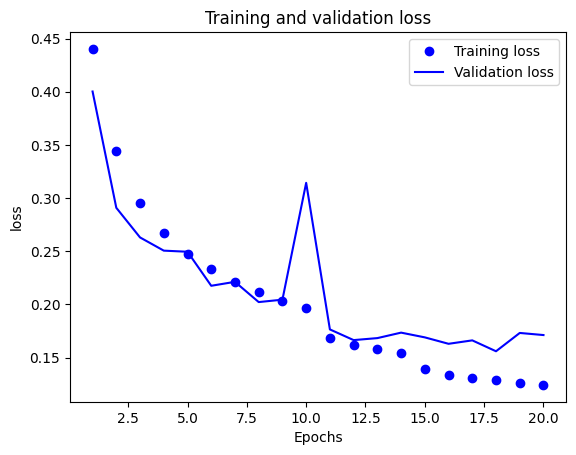

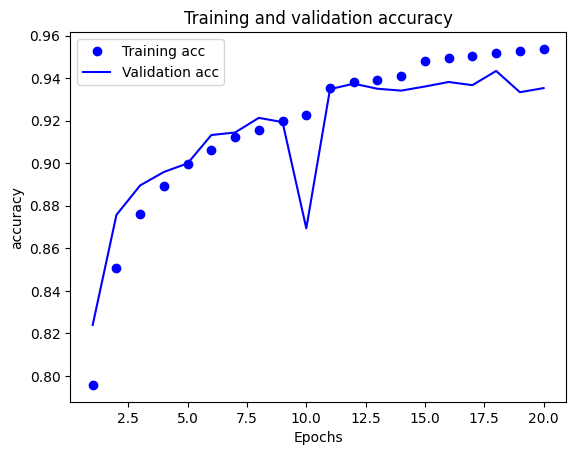

<Figure size 640x480 with 0 Axes>

In [26]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

## Step 8 - Use the weights to make a prediction

In [27]:
# make a prediction
predictions = model.predict(test_gen, steps=len(df_val), verbose=1)

16000/16000 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step


In [28]:
predictions.shape

(16000, 2)

In [29]:
# This is how to check what index keras has internally assigned to each class. 
test_gen.class_indices

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}

In [30]:
# Put the predictions into a dataframe.
# The columns need to be ordered to match the output of the previous cell

df_preds = pd.DataFrame(predictions, columns=['no_tumor_tissue', 'has_tumor_tissue'])

df_preds.head()

,no_tumor_tissue,has_tumor_tissue
0,1.000000,6.925594e-09
1,0.999387,6.129476e-04
2,0.999992,8.396406e-06
3,0.999621,3.793211e-04
4,1.000000,9.809436e-14


In [31]:
# Get the true labels
y_true = test_gen.classes

# Get the predicted labels as probabilities
y_pred = df_preds['has_tumor_tissue']

In [32]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_true, y_pred)

0.9849172265625

In [33]:
# Get the labels of the test images.

test_labels = test_gen.classes
test_labels.shape

(16000,)

In [34]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
# Print the label associated with each class
test_gen.class_indices

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}

In [35]:
# Delete base_dir and it's sub folders to free up disk space.
shutil.rmtree('base_dir')



# create test_dir
test_dir = 'test_dir'
os.mkdir(test_dir)
    
# create test_images inside test_dir
test_images = os.path.join(test_dir, 'test_images')
os.mkdir(test_images)
# check that the directory we created exists
os.listdir('test_dir')

['test_images']

In [36]:
# Transfer the test images into image_dir

test_list = os.listdir('../input/histopathologic-cancer-detection/test')

for image in test_list:
    
    fname = image
    
    
    src = os.path.join('../input/histopathologic-cancer-detection/test', fname)
    dst = os.path.join(test_images, fname)
    shutil.copyfile(src, dst)
    
# check that the images are now in the test_images
# Should now be 57458 images in the test_images folder
len(os.listdir('test_dir/test_images'))

57458

In [37]:
test_path ='test_dir'



test_gen = datagen.flow_from_directory(test_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 57458 images belonging to 1 classes.


In [38]:
num_test_images = 57458



predictions = model.predict(test_gen, steps=num_test_images, verbose=1)

57458/57458 ━━━━━━━━━━━━━━━━━━━━ 126s 2ms/step


In [39]:
# Are the number of predictions correct? it should be 57458.

len(predictions)

57458

## Step 9 - Make a submission dataframe with all the predictions

In [40]:
# Put the predictions into a dataframe

df_preds = pd.DataFrame(predictions, columns=['no_tumor_tissue', 'has_tumor_tissue'])

df_preds.head()

,no_tumor_tissue,has_tumor_tissue
0,5.816108e-08,1.000000
1,4.305423e-06,0.999996
2,8.764915e-06,0.999991
3,9.761380e-01,0.023862
4,9.998609e-01,0.000139


In [41]:
# This outputs the file names in the sequence in which 
# the generator processed the test images.
test_filenames = test_gen.filenames

# add the filenames to the dataframe
df_preds['file_names'] = test_filenames

df_preds.head()

,no_tumor_tissue,has_tumor_tissue,file_names
0,5.816108e-08,1.000000,test_images/00006537328c33e284c973d7b39d340809...
1,4.305423e-06,0.999996,test_images/0000ec92553fda4ce39889f9226ace43ca...
2,8.764915e-06,0.999991,test_images/00024a6dee61f12f7856b0fc6be20bc7a4...
3,9.761380e-01,0.023862,test_images/000253dfaa0be9d0d100283b22284ab2f6...
4,9.998609e-01,0.000139,test_images/000270442cc15af719583a8172c87cd2bd...


In [42]:
# Create an id column


def extract_id(x):
    
    # split into a list
    a = x.split('/')
    # split into a list
    b = a[1].split('.')
    extracted_id = b[0]
    
    return extracted_id

df_preds['id'] = df_preds['file_names'].apply(extract_id)

df_preds.head()

,no_tumor_tissue,has_tumor_tissue,file_names,id
0,5.816108e-08,1.000000,test_images/00006537328c33e284c973d7b39d340809...,00006537328c33e284c973d7b39d340809f7271b
1,4.305423e-06,0.999996,test_images/0000ec92553fda4ce39889f9226ace43ca...,0000ec92553fda4ce39889f9226ace43cae3364e
2,8.764915e-06,0.999991,test_images/00024a6dee61f12f7856b0fc6be20bc7a4...,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2
3,9.761380e-01,0.023862,test_images/000253dfaa0be9d0d100283b22284ab2f6...,000253dfaa0be9d0d100283b22284ab2f6b643f6
4,9.998609e-01,0.000139,test_images/000270442cc15af719583a8172c87cd2bd...,000270442cc15af719583a8172c87cd2bd9c7746


In [43]:
# Get the predicted labels.
# We were asked to predict a probability that the image has tumor tissue
y_pred = df_preds['has_tumor_tissue']

# get the id column
image_id = df_preds['id']

## Step 10 - Create a submission.csv file

In [44]:
submission = pd.DataFrame({'id':image_id, 
                           'label':y_pred, 
                          }).set_index('id')

submission.to_csv('patch_preds.csv', columns=['label']) 
submission.head()

,label
id,
00006537328c33e284c973d7b39d340809f7271b,1.000000
0000ec92553fda4ce39889f9226ace43cae3364e,0.999996
00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.999991
000253dfaa0be9d0d100283b22284ab2f6b643f6,0.023862
000270442cc15af719583a8172c87cd2bd9c7746,0.000139


In [45]:
# Delete the test_dir directory we created to prevent a Kaggle error.
# Kaggle allows a max of 500 files to be saved.

shutil.rmtree('test_dir')

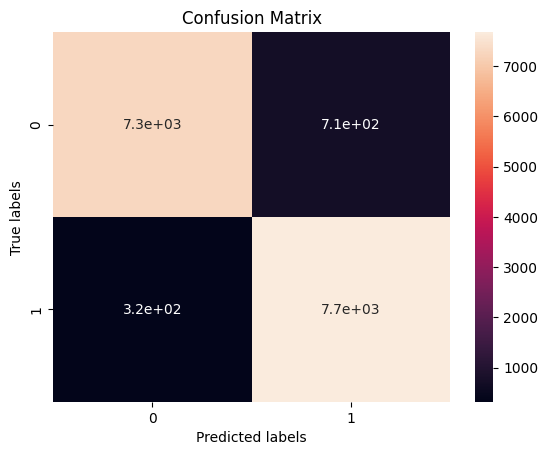

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');